In [122]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import sys

In [2]:
tips = pd.read_csv("yelp_data/yelp_academic_dataset_tip.csv")

In [97]:
businesses = pd.read_csv("yelp_data/yelp_academic_dataset_business.csv")

In [98]:
businesses= businesses[[u'business_id',u'categories']]


In [5]:
tips = tips[[u'text',u'business_id',u'likes']]

In [6]:
dataset = pd.merge(tips, businesses, on=u'business_id')

In [33]:
len(dataset)

648902

In [7]:
reviews = pd.read_csv("yelp_data/yelp_academic_dataset_review.csv")

In [8]:
dataset_reviews = pd.merge(reviews, businesses, on=u'business_id')

In [25]:
reviews.head()

,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful
0,PUFPaY9KxDAcGqfsorJp3Q,Ya85v4eqdd6k9Od8HbQjyA,"Mr Hoagie is an institution. Walking in, it do...",0,5UmKMjUEUNdYWqANhGckJw,0,4,2012-08-01,review,0
1,Iu6AxdBYGR4A0wspR9BYHA,KPvLNJ21_4wbYNctrOwWdQ,Excellent food. Superb customer service. I mis...,0,5UmKMjUEUNdYWqANhGckJw,0,5,2014-02-13,review,0
2,auESFwWvW42h6alXgFxAXQ,fFSoGV46Yxuwbr3fHNuZig,Yes this place is a little out dated and not o...,0,5UmKMjUEUNdYWqANhGckJw,1,5,2015-10-31,review,1
3,qiczib2fO_1VBG8IoCGvVg,pVMIt0a_QsKtuDfWVfSk2A,PROS: Italian hoagie was delicious. Friendly ...,0,5UmKMjUEUNdYWqANhGckJw,0,3,2015-12-26,review,0
4,qEE5EvV-f-s7yHC0Z4ydJQ,AEyiQ_Y44isJmNbMTyoMKQ,First the only reason this place could possibl...,0,5UmKMjUEUNdYWqANhGckJw,0,2,2016-04-08,review,1


In [26]:
dataset.head()

,text,business_id,likes,categories
0,Pizza is garbage. Hoagies are excellent.,5UmKMjUEUNdYWqANhGckJw,0,"['Fast Food', 'Restaurants']"
1,Don't waste your time.,cE27W9VPgO88Qxe4ol6y_g,0,"['Active Life', 'Mini Golf', 'Golf']"
2,Not easy to find. Be sure to put in directions...,mVHrayjG3uZ_RLHkLj-AMg,0,"['Bars', 'American (New)', 'Nightlife', 'Loung..."
3,Your GPS will not allow you to find this place...,mVHrayjG3uZ_RLHkLj-AMg,1,"['Bars', 'American (New)', 'Nightlife', 'Loung..."
4,Great drink specials!,KayYbHCt-RkbGcPdGOThNg,0,"['Bars', 'American (Traditional)', 'Nightlife'..."


In [9]:
#dataset_reviews.to_csv('dataset_reviews.csv')

In [62]:
reviews_by_bis=dataset.groupby([u'business_id'])[u'text'].apply(lambda x: "{%s}" % ', '.join(x))

In [63]:
reviews_by_bis_df = reviews_by_bis.to_frame()

In [67]:
reviews_by_bis_df = reviews_by_bis_df.reset_index()

In [174]:
reviews_by_bis['RtwOc-n_RkiUuDGaNfCsNw']

'{yum!, I love coming here. Great food, clean and they accommodate my taste buds every time. Fry sauce rocks!, You\'ll be stuffed, but save room for the bread pudding!, Best cheese steaks around!!! Great service & atmosphere., Mmmmmm., Staff is friendly, and the food come flying out of the kitchen., Sweet potato fries with honey mustard sauce!, Authentic Philly!, Love this True American joint!!!, Great cheesesteaks and service., Good, but it isn\'t any better than Corleone\'s.  Little skimpy on cheese fry portion.  Overall it was good., Very good steaks, little pricey for large but totally filling., Hands down one of my favorite places to grab a bite to eat. Try it if you have not., Best cheesesteak in the valley. WHIZ ALL DAY, Sweet potato fries are a must! And you must try their side salad with their homemade vinagrette dressing. It\'s pizza sauce! Unbelievable!!!, Mmmm steak salad...., Great Buffalo chicken sandwiches! Also, a surprise house feature iced mocha drink. Addictive., Bes

In [69]:
text = reviews_by_bis_df['text']

## Stopwords, stemming, and tokenizing

In [10]:
# load nltk's English stopwords as variable called 'stopwords'
# nltk.download()
stopwords = nltk.corpus.stopwords.words('english')

In [11]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [12]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.

In [77]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in text:
    i = i.encode('ascii', errors='ignore')
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [20]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [79]:
'there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame'

'there are 1061940 items in vocab_frame'

## LDA

In [216]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    #text = text.encode('ascii', errors='ignore')
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [214]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    #text = text.encode('ascii', errors='ignore')
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [257]:
from gensim import corpora, models, similarities 

test1 = dataset[dataset['business_id']=='RtwOc-n_RkiUuDGaNfCsNw']['text'].apply(str)

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in test1]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

In [258]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [262]:
texts

[[u'yum'],
 [u'love',
  u'come',
  u'food',
  u'clean',
  u'accommod',
  u'tast',
  u'bud',
  u'everi',
  u'time',
  u'sauc',
  u'rock'],
 [u'stuf', u'save', u'room', u'bread', u'pud'],
 [u'chees', u'steak', u'around', u'servic', u'atmospher'],
 [],
 [u'friend', u'food', u'come', u'fli', u'kitchen'],
 [u'potato', u'fri', u'honey', u'mustard', u'sauc'],
 [],
 [u'joint'],
 [u'cheesesteak', u'servic'],
 [u"n't",
  u'ani',
  u'better',
  "'s",
  u'skimpi',
  u'chees',
  u'fri',
  u'portion',
  u'good'],
 [u'good', u'steak', u'littl', u'pricey', u'larg', u'total', u'fill'],
 [u'one', u'favorit', u'place', u'grab', u'bite', u'eat'],
 [u'cheesesteak', u'valley'],
 [u'potato',
  u'fri',
  u'must',
  u'must',
  u'tri',
  u'side',
  u'salad',
  u'homemad',
  u'vinagrett',
  u'dress',
  "'s",
  u'pizza',
  u'sauc'],
 [u'steak', u'salad'],
 [u'chicken',
  u'sandwich',
  u'surpris',
  u'hous',
  u'featur',
  u'ice',
  u'mocha',
  u'drink'],
 [u'cheesesteak', u'ever', u'put', u'mouth', u'great', u's

In [281]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

In [282]:
lda.show_topics()

[(0,
  u'0.046*"place" + 0.037*"servic" + 0.037*"great" + 0.037*"food" + 0.028*"cheesesteak" + 0.028*"chees" + 0.020*"guy" + 0.020*"come" + 0.019*"take" + 0.019*"valley"'),
 (1,
  u'0.064*"chees" + 0.049*"steak" + 0.047*"good" + 0.041*"cheesesteak" + 0.033*"servic" + 0.025*"n\'t" + 0.024*"fri" + 0.017*"wiz" + 0.017*"recommend" + 0.017*"though"'),
 (2,
  u'0.075*"fri" + 0.052*"sauc" + 0.035*"potato" + 0.027*"sweet" + 0.027*"delici" + 0.019*"get" + 0.019*"drink" + 0.019*"sandwich" + 0.019*"n\'t" + 0.010*"amaz"'),
 (3,
  u'0.025*"\'s" + 0.025*"place" + 0.025*"go" + 0.025*"definit" + 0.021*"fri" + 0.019*"chees" + 0.017*"fast" + 0.017*"cheesesteak" + 0.017*"clean" + 0.017*"time"'),
 (4,
  u'0.052*"steak" + 0.040*"good" + 0.027*"sandwich" + 0.027*"salad" + 0.027*"bread" + 0.027*"chees" + 0.015*"well" + 0.015*"larg" + 0.015*"eat" + 0.015*"delici"')]

In [283]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)


In [284]:
topics_matrix

[(0,
  [(u'place', 0.046180804808228788),
   (u'servic', 0.03736401417872607),
   (u'great', 0.037345416347302152),
   (u'food', 0.037283981582704399),
   (u'cheesesteak', 0.028449974663059915),
   (u'chees', 0.028347410278382456),
   (u'guy', 0.019527495006247751),
   (u'come', 0.019516533870939913),
   (u'take', 0.019493992020389928),
   (u'valley', 0.019487503811125313),
   (u'good', 0.019449887525630174),
   (u'steak', 0.01943611722744016),
   (u'disappoint', 0.010643356158508083),
   (u'even', 0.010642272110714992),
   (u'make', 0.010642082663825698),
   (u'get', 0.010638012136418552),
   (u'els', 0.010635173097107787),
   (u'wiz', 0.010634513672003109),
   (u'favor', 0.010633027084990853),
   (u'magnet', 0.010633027084983654)]),
 (1,
  [(u'chees', 0.0635051451512922),
   (u'steak', 0.049141994190678842),
   (u'good', 0.046655175039244851),
   (u'cheesesteak', 0.041138618032518684),
   (u'servic', 0.033179165883709269),
   (u"n't", 0.025437723047729142),
   (u'fri', 0.023990474533

In [278]:
businesses[businesses['business_id']=='RtwOc-n_RkiUuDGaNfCsNw']['categories'].tolist()

["['Food', 'Desserts', 'Cheesesteaks', 'Sandwiches', 'Restaurants']"]

In [300]:
import os.path

my_file= "../file_reviews/test1_reviews.txt"
with open(my_file, "w") as f:
    for row in test1:
        f.write(row)
    f.close()

In [317]:
lda.get_document_topics(corpus[3])

[(0, 0.033987104614358117),
 (1, 0.53657005613370612),
 (2, 0.36207544079173537),
 (3, 0.03356819312551184),
 (4, 0.033799205334688456)]

In [320]:
K = lda.num_topics
topicWordProbMat = lda.print_topics(K)

In [321]:
topicWordProbMat

[(0,
  u'0.046*"place" + 0.037*"servic" + 0.037*"great" + 0.037*"food" + 0.028*"cheesesteak" + 0.028*"chees" + 0.020*"guy" + 0.020*"come" + 0.019*"take" + 0.019*"valley"'),
 (1,
  u'0.064*"chees" + 0.049*"steak" + 0.047*"good" + 0.041*"cheesesteak" + 0.033*"servic" + 0.025*"n\'t" + 0.024*"fri" + 0.017*"wiz" + 0.017*"recommend" + 0.017*"though"'),
 (2,
  u'0.075*"fri" + 0.052*"sauc" + 0.035*"potato" + 0.027*"sweet" + 0.027*"delici" + 0.019*"get" + 0.019*"drink" + 0.019*"sandwich" + 0.019*"n\'t" + 0.010*"amaz"'),
 (3,
  u'0.025*"\'s" + 0.025*"place" + 0.025*"go" + 0.025*"definit" + 0.021*"fri" + 0.019*"chees" + 0.017*"fast" + 0.017*"cheesesteak" + 0.017*"clean" + 0.017*"time"'),
 (4,
  u'0.052*"steak" + 0.040*"good" + 0.027*"sandwich" + 0.027*"salad" + 0.027*"bread" + 0.027*"chees" + 0.015*"well" + 0.015*"larg" + 0.015*"eat" + 0.015*"delici"')]

In [323]:
# Prints the topics.
for top in lda.print_topics():
    print (top)

In [324]:
lda.print_topics()

[(0,
  u'0.046*"place" + 0.037*"servic" + 0.037*"great" + 0.037*"food" + 0.028*"cheesesteak" + 0.028*"chees" + 0.020*"guy" + 0.020*"come" + 0.019*"take" + 0.019*"valley"'),
 (1,
  u'0.064*"chees" + 0.049*"steak" + 0.047*"good" + 0.041*"cheesesteak" + 0.033*"servic" + 0.025*"n\'t" + 0.024*"fri" + 0.017*"wiz" + 0.017*"recommend" + 0.017*"though"'),
 (2,
  u'0.075*"fri" + 0.052*"sauc" + 0.035*"potato" + 0.027*"sweet" + 0.027*"delici" + 0.019*"get" + 0.019*"drink" + 0.019*"sandwich" + 0.019*"n\'t" + 0.010*"amaz"'),
 (3,
  u'0.025*"\'s" + 0.025*"place" + 0.025*"go" + 0.025*"definit" + 0.021*"fri" + 0.019*"chees" + 0.017*"fast" + 0.017*"cheesesteak" + 0.017*"clean" + 0.017*"time"'),
 (4,
  u'0.052*"steak" + 0.040*"good" + 0.027*"sandwich" + 0.027*"salad" + 0.027*"bread" + 0.027*"chees" + 0.015*"well" + 0.015*"larg" + 0.015*"eat" + 0.015*"delici"')]

In [327]:
# write out coordinates to file
fcoords = open(os.path.join("./", "coords.csv"), 'wb')
for vector in lda[corpus]:
    if len(vector) != 2:
        continue
    fcoords.write("%6.4f\t%6.4f\n" % (vector[0][1], vector[1][1]))
fcoords.close()

In [331]:
lda.print_topics()

[(0,
  u'0.046*"place" + 0.037*"servic" + 0.037*"great" + 0.037*"food" + 0.028*"cheesesteak" + 0.028*"chees" + 0.020*"guy" + 0.020*"come" + 0.019*"take" + 0.019*"valley"'),
 (1,
  u'0.064*"chees" + 0.049*"steak" + 0.047*"good" + 0.041*"cheesesteak" + 0.033*"servic" + 0.025*"n\'t" + 0.024*"fri" + 0.017*"wiz" + 0.017*"recommend" + 0.017*"though"'),
 (2,
  u'0.075*"fri" + 0.052*"sauc" + 0.035*"potato" + 0.027*"sweet" + 0.027*"delici" + 0.019*"get" + 0.019*"drink" + 0.019*"sandwich" + 0.019*"n\'t" + 0.010*"amaz"'),
 (3,
  u'0.025*"\'s" + 0.025*"place" + 0.025*"go" + 0.025*"definit" + 0.021*"fri" + 0.019*"chees" + 0.017*"fast" + 0.017*"cheesesteak" + 0.017*"clean" + 0.017*"time"'),
 (4,
  u'0.052*"steak" + 0.040*"good" + 0.027*"sandwich" + 0.027*"salad" + 0.027*"bread" + 0.027*"chees" + 0.015*"well" + 0.015*"larg" + 0.015*"eat" + 0.015*"delici"')]

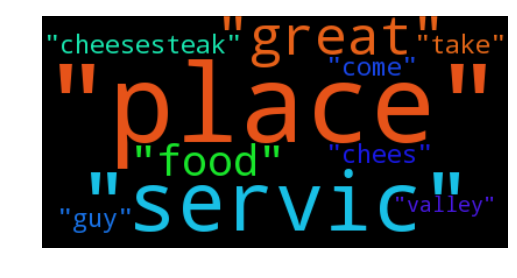

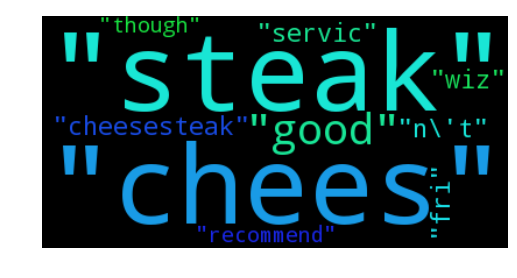

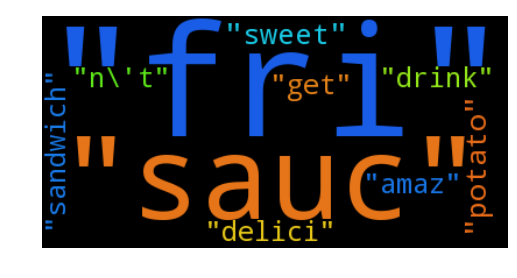

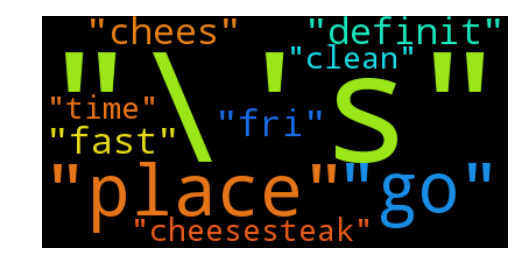

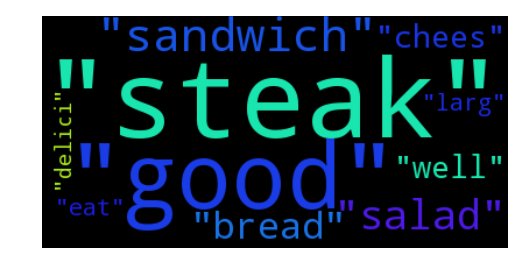

In [343]:
import os
from wordcloud import WordCloud

MODELS_DIR = "./"

wordcloud = WordCloud()

final_topics = open(os.path.join(MODELS_DIR, "final_topics.txt"), 'rb')
curr_topic = 0
for line in final_topics:
    line = line.strip()[line.rindex(":") + 2:]
    scores = [float(x.split("*")[0]) for x in line.split(" + ")]
    words = [x.split("*")[1] for x in line.split(" + ")]
    freqs = []
    for word, score in zip(words, scores):
        freqs.append((word, score))
    elements = wordcloud.fit_words(freqs)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    curr_topic += 1
final_topics.close()

# Display the generated image:
# the matplotlib way:


